In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mesh import create_2d_circle, create_toy_mesh
from discretization import create_discretization_element, create_discretization_mesh
from solver_bvp import BVP_Poisson_solver, get_n_element_operators
from solver_ivp import AdvectionIVPSolver2D
from scipy.integrate import solve_ivp

from mesh import Mesh
from discretization import DiscretizationElement, DiscretizationMesh
import numpy.typing as npt

import warnings
warnings.filterwarnings('ignore')

## Rotating hill

In [2]:
x_0, y_0 = -0.75, -0.25
sigma = 0.1

def get_hill_center(
    t: float, *, x_0: npt.NDArray, y_0: npt.NDArray
) -> tuple[npt.NDArray, npt.NDArray]:
    omega = 2 * np.pi
    x_t = x_0 * np.cos(omega * t) + y_0 * np.sin(omega * t)
    y_t = -x_0 * np.sin(omega * t) + y_0 * np.cos(omega * t)
    return x_t, y_t

def u_exact_hill(x, y, t, sigma=sigma):
    x_center_t, y_center_t = get_hill_center(t, x_0=x_0, y_0=y_0)
    return np.exp(-((x - x_center_t) ** 2 + (y - y_center_t) ** 2) / (2 * sigma**2))

def u_exact_hill_dt(x, y, t, x_0=x_0, y_0=y_0, sigma=sigma):
    omega = 2 * np.pi
    xc, yc = get_hill_center(t, x_0=x_0, y_0=y_0)
    xc_t = omega * yc
    yc_t = -omega * xc
    u = u_exact_hill(x, y, t, sigma=sigma)
    return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)

def f_rhs_hill(x: npt.NDArray, y: npt.NDArray, t: float) -> npt.NDArray:
    return np.zeros_like(x)

def advection_velocity_field(x: npt.NDArray, y: npt.NDArray) -> tuple[npt.NDArray, npt.NDArray]:
    return (2 * np.pi * y, -2 * np.pi * x)

In [84]:
V_x = np.array([-1, 1, -1])
V_y = np.array([-1, 1, 1])
EtoV = np.array([[0, 1, 2]])
mesh_hill_1 = create_toy_mesh(V_x, V_y, EtoV)

# V_x = np.array([-1, 1, 1, -1])
# V_y = np.array([-1, -1, 1, 1])
# EtoV = np.array([[1, 2, 4], [2, 3, 4]]) - 1
# mesh_hill_1 = create_toy_mesh(V_x, V_y, EtoV)

N = 20
discretization_element_hill_1 = create_discretization_element(N = N, LocalReorder = np.arange((N+1)*(N+2)//2))
# discretization_element_hill_1 = create_discretization_element(N = N)
discretization_mesh_hill_1 = create_discretization_mesh(mesh = mesh_hill_1, discretization_element = discretization_element_hill_1)

r, s = discretization_element_hill_1.r, discretization_element_hill_1.s
x_global, y_global = discretization_mesh_hill_1.x_global, discretization_mesh_hill_1.y_global
print(f"{x_global.shape = }")

x_global.shape = (231,)


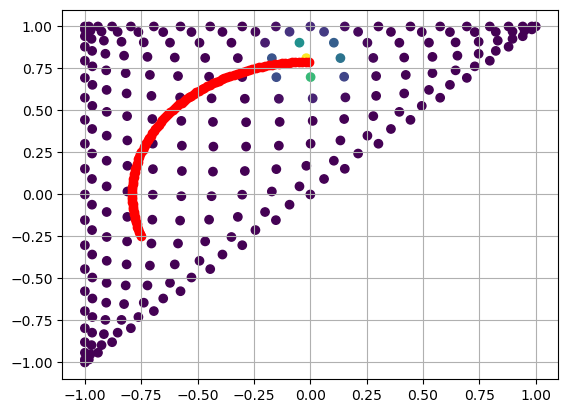

In [85]:
t_max = 0.3
t_array = np.linspace(0, t_max, 100)
x_center_t, y_center_t = get_hill_center(t_array, x_0=x_0, y_0=y_0)

u_true_t = u_exact_hill(x_global, y_global, t=t_array[:, None])
u_0 = u_exact_hill(x_global, y_global, t=0)

plt.scatter(x_global, y_global, c=u_true_t[-1, :], cmap='viridis')
# plt.scatter(x_global, y_global, c=u_0, cmap='viridis')
plt.scatter(x_center_t, y_center_t, color='red')
plt.grid();

## Solver Jeppe

In [124]:
solver_jeppe = AdvectionIVPSolver2D(
    mesh = mesh_hill_1,
    discretization_element = discretization_element_hill_1,
    discretization_mesh = discretization_mesh_hill_1,
    f_rhs = f_rhs_hill,
    g_bc = u_exact_hill,
    g_bc_dt = u_exact_hill_dt,
    advection_velocity_field = advection_velocity_field
)

dudt = solver_jeppe.get_rhs_IVP(t=0, u=u_0)
# print(dudt.shape, u_0.shape)

In [125]:
print(t_max)
t0, tf = 0.0, t_max
u_0 = u_exact_hill(x_global, y_global, t=0)
result_scipy = solve_ivp(
    solver_jeppe.get_rhs_IVP,
    [t0, tf],
    y0 = u_0,
    method = "RK45",
    # max_step = max_step,
    # rtol=rtol,
    # atol=atol
)

0.3


(231, 76)
err.shape = (231, 76)
(60,)
(231, 76)


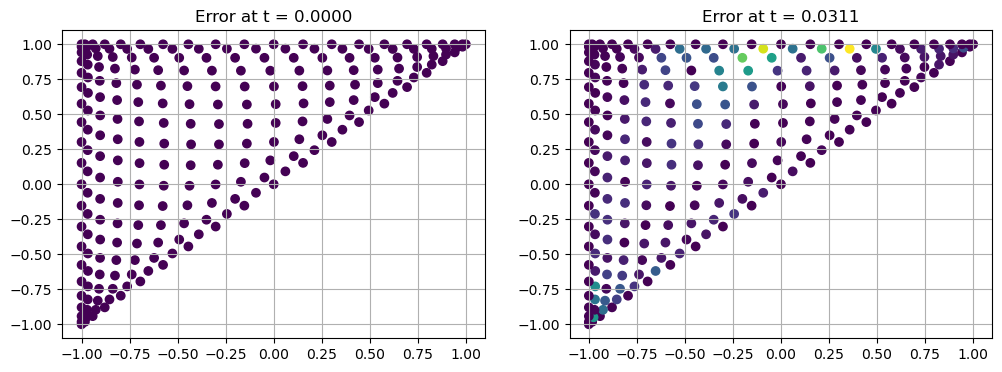

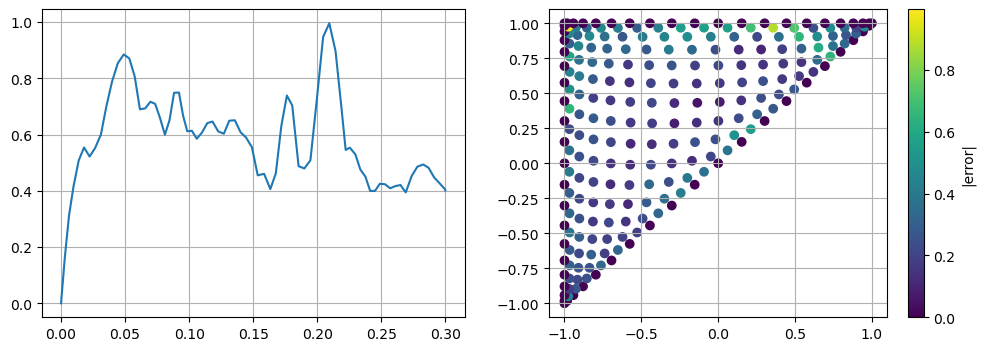

In [126]:
u_N_t = result_scipy.y
print(u_N_t.shape)

t_ivp_solver = result_scipy.t

u_true_ivp_solver = u_exact_hill(x_global, y_global, t=t_ivp_solver[:, None])
u_true_ivp_solver = u_true_ivp_solver.T

err = np.abs(u_true_ivp_solver - u_N_t)
norm_err_t = np.linalg.norm(err, ord = np.inf, axis=0)
norm_err_xy = np.linalg.norm(err, ord = np.inf, axis=1)
print(f"{err.shape = }")

print(discretization_mesh_hill_1.BC_nodes.shape)
print(err.shape)
np.linalg.norm(err[discretization_mesh_hill_1.BC_nodes], axis = 0, ord = np.inf)

t_test_1, t_test_2 = 0, 10

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x_global, y_global, c = err[:, t_test_1])
ax[0].set_title(f"Error at t = {t_ivp_solver[t_test_1]:.4f}")
ax[0].grid();
ax[1].scatter(x_global, y_global, c = err[:, t_test_2])
ax[1].set_title(f"Error at t = {t_ivp_solver[t_test_2]:.4f}")
ax[1].grid();

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_ivp_solver, norm_err_t)
ax[0].grid();
sc = ax[1].scatter(x_global, y_global, c = norm_err_xy)
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

In [91]:
# energy_array = np.zeros(t_ivp_solver.shape[0])
# for t in range(t_ivp_solver.shape[0]):
#     energy_array[t] = 0.5 * u_N_t[:, t].T @ ivp_hill_solver_1.M_global @ u_N_t[:, t]

# plt.plot(energy_array)
# plt.grid();

In [127]:
def solve_ivp_convergence(N, t_max = 1):
    
    discretization_element_hill_1 = create_discretization_element(N = N)
    discretization_mesh_hill_1 = create_discretization_mesh(mesh = mesh_hill_1, discretization_element = discretization_element_hill_1)

    # r, s = discretization_element_hill_1.r, discretization_element_hill_1.s
    x_global, y_global = discretization_mesh_hill_1.x_global, discretization_mesh_hill_1.y_global

    ivp_hill_solver_1 = AdvectionIVPSolver2D(
        mesh = mesh_hill_1,
        discretization_element = discretization_element_hill_1,
        discretization_mesh = discretization_mesh_hill_1,
        f_rhs = f_rhs_hill,
        g_bc = u_exact_hill,
        g_bc_dt = u_exact_hill_dt,
        advection_velocity_field = advection_velocity_field
    )

    u_0 = u_exact_hill(x_global, y_global, t=0)
    result_scipy = solve_ivp(
        ivp_hill_solver_1.get_rhs_IVP,
        [t0, t_max],
        y0 = u_0,
        method = "RK45",
        # max_step = max_step,
        # rtol=rtol,
        # atol=atol
    )
    print(f"{N = }, {result_scipy.success = }")

    u_t_max = u_exact_hill(x_global, y_global, t=t_max)
    u_num_t_max = result_scipy.y[:, -1]
    err_t_max = np.abs(u_t_max - u_num_t_max)

    error_inf_norm = np.linalg.norm(err_t_max, ord = np.inf)
    # error_inf_norm = np.linalg.norm(err_t_max, ord = 2)

    return error_inf_norm

In [128]:
N_array = np.arange(5, 20)
error_array = np.zeros(N_array.shape[0])

for i, N in enumerate(tqdm(N_array)):
    error_array[i] = solve_ivp_convergence(N, t_max = 1)

 33%|███▎      | 5/15 [00:00<00:00, 48.79it/s]

N = np.int64(5), result_scipy.success = True
N = np.int64(6), result_scipy.success = True
N = np.int64(7), result_scipy.success = True
N = np.int64(8), result_scipy.success = True
N = np.int64(9), result_scipy.success = True
N = np.int64(10), result_scipy.success = True
N = np.int64(11), result_scipy.success = True


 67%|██████▋   | 10/15 [00:00<00:00, 20.81it/s]

N = np.int64(12), result_scipy.success = True
N = np.int64(13), result_scipy.success = True
N = np.int64(14), result_scipy.success = True
N = np.int64(15), result_scipy.success = True
N = np.int64(16), result_scipy.success = True


 87%|████████▋ | 13/15 [00:00<00:00, 11.87it/s]

N = np.int64(17), result_scipy.success = True
N = np.int64(18), result_scipy.success = True


100%|██████████| 15/15 [00:01<00:00,  9.78it/s]

N = np.int64(19), result_scipy.success = True


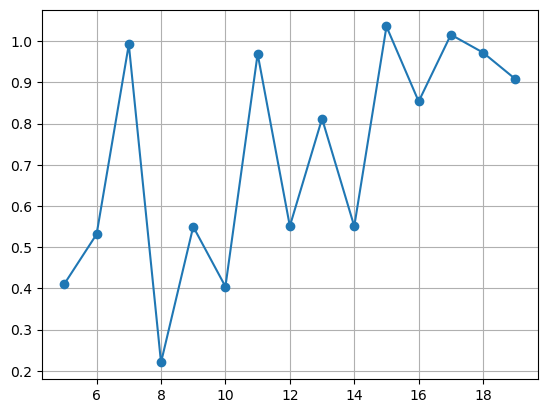

In [129]:
plt.plot(N_array, error_array, marker='o')
plt.grid();

## Solver Tymek

In [7]:
# based on section 5.2 FEM book, equation 5.15
class IVP_hill_solver():
    """
    solve du_dt = - (a_x * du_dx + a_y * du_dy)
    discretization SEM: M du_dt = - L u + f
    """

    def __init__(self, mesh: Mesh, discretization_element: DiscretizationElement, discretization_mesh: DiscretizationMesh,
                g_bc, g_bc_dt, f_rhs, advection_velocity_field):
        self.mesh = mesh
        self.discretization_element = discretization_element
        self.discretization_mesh = discretization_mesh
        self.advection_velocity_field = advection_velocity_field
        self.g_bc = g_bc  # function (x, y, t)
        self.g_bc_dt = g_bc_dt
        self.f_rhs = f_rhs  # function (x, y, t)
        self.L_N_list = list()
        self.f_N_list = list()
        self.M_global_list = list()
        # self.Chol_M_global = None
        # self.Chol_lower = None
        self.t_list = list()

        # Assemble constant matrices immediately (since velocity field is stationary)

    def construct_L_n_element_t(self, Dx, Dy, M, x_n, y_n, t):
        # this element is stationary

        # x_center_t, y_center_t = get_hill_center(t)
        # return 2*np.pi * (y_center_t * Dx - x_center_t * Dy) @ M
        # return 2*np.pi * M @ (y_center_t * Dx - x_center_t * Dy)

        ax, ay = self.advection_velocity_field(x_n, y_n)
        return M @ (np.diag(ax) @ Dx + np.diag(ay) @ Dy)

    def construct_global_assembly_t(self, t):
    # def construct_global_assembly(self):
        # we assume stationary velocity field; construct L_N, f_N

        L_N_t = np.zeros((self.discretization_mesh.gidx, self.discretization_mesh.gidx))
        f_N_t = np.zeros(self.discretization_mesh.gidx)
        M_global_t = np.zeros((self.discretization_mesh.gidx, self.discretization_mesh.gidx))

        Mp = self.discretization_element.Mp
        C = self.discretization_mesh.C
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        # Allan FEM book: Algo 15, 16
        # for n_element in tqdm(range(self.mesh.num_elements)):
        for n_element in range(self.mesh.num_elements):

            x_vertex_n = self.mesh.V_x[self.mesh.EtoV[n_element, :]]
            y_vertex_n = self.mesh.V_y[self.mesh.EtoV[n_element, :]]

            v1_n = np.array([x_vertex_n[0], y_vertex_n[0]])
            v2_n = np.array([x_vertex_n[1], y_vertex_n[1]])
            v3_n = np.array([x_vertex_n[2], y_vertex_n[2]])

            Dx, Dy, M, x_n, y_n = get_n_element_operators(
                discretization_element=self.discretization_element,
                v1_n=v1_n, v2_n=v2_n, v3_n=v3_n
            )

            L_n_element_t = self.construct_L_n_element_t(t=None, Dx=Dx, Dy=Dy, M=M, x_n=x_n, y_n=y_n)

            for j in range(Mp):
                for i in range(Mp):
                    # exploit symmetry, not working
                    # if C[n_element, j] >= C[n_element, i]:
                    L_N_t[C[n_element, i], C[n_element, j]] += L_n_element_t[i, j]

            for j in range(Mp):
                jj = C[n_element, j]
                x_j = x_global[jj]
                y_j = y_global[jj]
                for i in range(Mp):
                    ii = C[n_element, i]
                    f_N_t[ii] += M[i, j] * self.f_rhs(x_j, y_j, t) # global assembly b_i(t) FEM
                    # f_N_t[ii] = self.f_rhs(x_j, y_j, t)

            # assembling of global Mass matrix
            # if self.M_global is None:
            for j in range(Mp):
                for i in range(Mp):
                    # exploit symmetry, not working
                    # if C[n_element, j] >= C[n_element, i]:
                    M_global_t[C[n_element, i], C[n_element, j]] += M[i, j]

        self.t_list.append(t)
        self.L_N_list.append(L_N_t)
        self.f_N_list.append(f_N_t)
        self.M_global_list.append(M_global_t)
        # if self.M_global is None:
        #     self.M_global = M_global_t

    def prescribe_boundary_conditions_t(self, t):

        BC_nodes = self.discretization_mesh.BC_nodes
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        L_N_t = self.L_N_list[-1].copy()
        f_N_t = self.f_N_list[-1].copy()
        M_global_t = self.M_global_list[-1].copy()

        # if self.Chol_lower is None:
        #     for i in BC_nodes:
        #         M_global[i, :] = 0.0
        #         M_global[:, i] = 0.0
        #         M_global[i, i] = 1.0
        #     self.M_global = M_global

        # Allan FEM book: Algo 17
        for i in BC_nodes:
            # correct: in FEM book the f function are KNOWN boundary conditions -> so u_exact
            u_i_t = self.g_bc(x_global[i], y_global[i], t = t)   # Dirichlet value
            u_i_t_dt = self.g_bc_dt(x_global[i], y_global[i], t = t)
            # # update ALL equations
            f_N_t = f_N_t - L_N_t[:, i] * u_i_t - M_global_t[:, i] * u_i_t_dt
            L_N_t[i, :] = 0.0
            L_N_t[:, i] = 0.0
            # L_N_t[i, i] = 1.0

            M_global_t[i, :] = 0.0
            M_global_t[:, i] = 0.0
            M_global_t[i, i] = 1.0

        for i in BC_nodes:
            # f_N_t[i] = self.g_bc(x_global[i], y_global[i], t=t)
            f_N_t[i] = self.g_bc_dt(x_global[i], y_global[i], t = t)

        self.L_N_list[-1] = L_N_t
        self.f_N_list[-1] = f_N_t
        self.M_global_list[-1] = M_global_t


    # def factorize_M_global(self):
    #     if self.Chol_lower is None:
    #         print("Factorizing M_global")
    #         Chol_M_global, Chol_lower = sp.linalg.cho_factor(self.M_global)
    #         self.Chol_M_global = Chol_M_global
    #         self.Chol_lower = Chol_lower


    def get_rhs_IVP(self, t, u):
        # put list here, better callback function 
        self.construct_global_assembly_t(t=t)
        self.prescribe_boundary_conditions_t(t=t)
        # self.factorize_M_global()

        # BC_nodes = self.discretization_mesh.BC_nodes
        # x_global = self.discretization_mesh.x_global
        # y_global = self.discretization_mesh.y_global

        M_global = self.M_global_list[-1]
        L_N_t = self.L_N_list[-1]
        f_N_t = self.f_N_list[-1]

        du_dt_M = - L_N_t @ u + f_N_t
        # du_dt = sp.linalg.cho_solve((self.Chol_M_global, self.Chol_lower), du_dt_M)
        du_dt = np.linalg.solve(M_global, du_dt_M)
        # if self.cb not None:
        #     self.cb(t, u, du_dt)
        return du_dt
    

In [8]:
solver_tb = IVP_hill_solver(
    mesh = mesh_hill_1,
    discretization_element = discretization_element_hill_1,
    discretization_mesh = discretization_mesh_hill_1,
    f_rhs = f_rhs_hill,
    g_bc = u_exact_hill,
    g_bc_dt = u_exact_hill_dt,
    advection_velocity_field = advection_velocity_field
)

# dudt = solver_tb.get_rhs_IVP(t=0, u=u_0)
# print(dudt.shape, u_0.shape)

In [ ]:
# print(t_max)
# t0, tf = 0.0, t_max
# u_0 = u_exact_hill(x_global, y_global, t=0)
# result_scipy_tb = solve_ivp(
#     solver_tb.get_rhs_IVP,
#     [t0, tf],
#     y0 = u_0,
#     method = "RK45",
#     # max_step = max_step,
#     # rtol=rtol,
#     # atol=atol
# )

# u_N_t = result_scipy.y
# print(u_N_t.shape)

# t_ivp_solver = result_scipy_tb.t

# u_true_ivp_solver = u_exact_hill(x_global, y_global, t=t_ivp_solver[:, None]).T

# err_tb = np.abs(u_true_ivp_solver - u_N_t)
# norm_err_t = np.linalg.norm(err_tb, ord = np.inf, axis=0)
# norm_err_xy = np.linalg.norm(err_tb, ord = np.inf, axis=1)
# print(f"{err.shape = }")

## Comparison

In [ ]:
M_global_jeppe = solver_jeppe.M_global.todense()
L_global_jeppe = solver_jeppe.L_global.todense()

solver_tb.construct_global_assembly_t(t=0)

M_global_tb = solver_tb.M_global_list[-1]
L_global_tb = solver_tb.L_N_list[-1]

In [19]:
print(f"{np.linalg.norm(M_global_tb - M_global_jeppe) = }")
# different if we use the split form, the split form puts ZERO on the diagonal
print(f"{np.linalg.norm(L_global_tb - L_global_jeppe) = }")

np.linalg.norm(M_global_tb - M_global_jeppe) = np.float64(0.0)
np.linalg.norm(L_global_tb - L_global_jeppe) = np.float64(0.0)


In [22]:
X = np.random.normal(size = (4, 4))
b = np.random.normal(size = (4, ))
u = np.linalg.solve(X, b)

In [43]:
X[1, :] = 0.0
X[1, 1] = 1.0
b[1] = 5
print(X)
print()
print(b)

u = np.linalg.solve(X, b)
print()
print(u)

[[-0.93746664  0.26786249 -0.62147573 -1.69994283]
 [ 0.          1.          0.          0.        ]
 [ 0.29663074  0.27958082  0.69148755 -1.20586962]
 [ 1.36090655  0.94085717  0.19005178 -1.01186358]]

[ 0.49019955  5.         -1.36321727  0.77934511]

[-1.62947946  5.         -0.52266906  1.58918384]


In [56]:
Y = X.copy()

Z = Y.copy()
Z[:, 0] = 0.0
Z[1, 1] = 0
Z[:, 2] = 0.0
Z[:, 3] = 0.0
print(Z)

b2 = b.copy()
b2[1] = 5
# print(Y[:, 1])
# print(b2)
print()
print(Z @ b2)
print(Y[:, 1] * 5)
print()
b2 = b2 - Y[:, 1] * 5
b2[1] = 5

Y[:, 1] = 0.0
Y[1, 1] = 1.0

print(Y)
print()
print(b2)
u2 = np.linalg.solve(Y, b2)
print()
print(u2)

[[0.         0.26786249 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.27958082 0.         0.        ]
 [0.         0.94085717 0.         0.        ]]

[1.33931246 0.         1.39790408 4.70428583]
[1.33931246 5.         1.39790408 4.70428583]

[[-0.93746664  0.         -0.62147573 -1.69994283]
 [ 0.          1.          0.          0.        ]
 [ 0.29663074  0.          0.69148755 -1.20586962]
 [ 1.36090655  0.          0.19005178 -1.01186358]]

[-0.8491129   5.         -2.76112136 -3.92494072]

[-1.62947946  5.         -0.52266906  1.58918384]


## Combined solver

In [ ]:
import scipy.sparse as sp

class SolverCombined:
    def __init__(
        self,
        mesh,
        discretization_element,
        discretization_mesh,
        advection_velocity_field,
        g_bc,
        g_bc_dt,
        f_rhs,
    ):
        self.mesh = mesh
        self.discretization_element = discretization_element
        self.discretization_mesh = discretization_mesh
        self.advection_velocity_field = advection_velocity_field
        self.g_bc = g_bc  # Boundary Condition u(x,y,t)
        self.g_bc_dt = g_bc_dt  # Time derivative of BC du/dt(x,y,t)
        self.f_rhs = f_rhs  # Source function f(x,y,t)
        self.L_global, self.M_global = self.construct_global_assembly()
        self.M_sys, self.L_sys = self.apply_matrix_bc()
        self.M_sys_solver = sp.linalg.factorized(self.M_sys.tocsc())

    def construct_L_n_element(self, Dx, Dy, M, x_nodes, y_nodes):
        ax, ay = self.advection_velocity_field(x_nodes, y_nodes)

        # Conservative form
        # Strong form advection operator on element: M @ (ax*Dx + ay*Dy)
        # Corresponds to (v, a.grad(u))
        return M @ (np.diag(ax) @ Dx + np.diag(ay) @ Dy)
        # return (np.diag(ax) @ Dx + np.diag(ay) @ Dy)

        # # Split form
        # MAx = np.diag(ax) @ M @ Dx
        # MAy = np.diag(ay) @ M @ Dy
        # return 1/2 * ((MAx - (MAx.T)) + MAy - (MAy.T))

    def construct_global_assembly(self) -> tuple[npt.NDArray, npt.NDArray]:
        """
        Implementation of Global Assembly based on FEM Book Algorithms 15 & 16.
        Modified for Advection (Non-Symmetric L).
        """
        # print("Assembling global matrices...")

        gidx = self.discretization_mesh.gidx

        # Use sparse matrix construction for efficiency
        # We collect triplets (row, col, value)
        L_rows, L_cols, L_vals = [], [], []
        M_rows, M_cols, M_vals = [], [], []

        C = self.discretization_mesh.C
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        # for n_element in tqdm(range(self.mesh.num_elements)):
        for n_element in range(self.mesh.num_elements):
            # 1. Get Element Geometry
            # (Assuming get_n_element_operators is available as in your snippet)
            # You might need to pass physical nodes to your operator function if it calculates metrics
            node_indices = C[n_element, :]
            x_nodes = x_global[node_indices]
            y_nodes = y_global[node_indices]

            # Reconstruct vertices for the metric terms if needed by your helper
            # (Assuming your existing helper works as before)
            x_vertex = self.mesh.V_x[self.mesh.EtoV[n_element, :]]
            y_vertex = self.mesh.V_y[self.mesh.EtoV[n_element, :]]
            v1 = np.array([x_vertex[0], y_vertex[0]])
            v2 = np.array([x_vertex[1], y_vertex[1]])
            v3 = np.array([x_vertex[2], y_vertex[2]])

            # Get local operators (Reference Dx, Dy and Metric-scaled M)
            Dx, Dy, M_local, _, _ = get_n_element_operators(
                discretization_element=self.discretization_element,
                v1_n=v1,
                v2_n=v2,
                v3_n=v3,
            )

            # Construct Local Advection Matrix L (Algorithm 15)
            L_local = self.construct_L_n_element(Dx, Dy, M_local, x_nodes, y_nodes)

            # 3. Add to lists for Sparse Assembly
            # Create meshgrid of indices for this element
            r_idx, c_idx = np.meshgrid(node_indices, node_indices, indexing="ij")

            L_rows.extend(r_idx.flatten())
            L_cols.extend(c_idx.flatten())
            L_vals.extend(L_local.flatten())

            M_rows.extend(r_idx.flatten())
            M_cols.extend(c_idx.flatten())
            M_vals.extend(M_local.flatten())

        # Create Sparse Matrices
        L_global = sp.coo_matrix((L_vals, (L_rows, L_cols)), shape=(gidx, gidx)).tocsr()
        M_global = sp.coo_matrix((M_vals, (M_rows, M_cols)), shape=(gidx, gidx)).tocsr()

        return L_global, M_global


    def apply_matrix_bc(self):
        M_sys = self.M_global.copy()
        L_sys = self.L_global.copy()
        bc_nodes = self.discretization_mesh.BC_nodes

        # M_sys[:, bc_nodes] = 0.0  # Zero out columns
        M_sys[bc_nodes, :] = 0.0  # Zero out rows
        M_sys[bc_nodes, bc_nodes] = 1.0  # Set diagonal to 1.0

        # Operator Matrix
        # L_sys[:, bc_nodes] = 0.0  # Zero out columns
        L_sys[bc_nodes, :] = 0.0  # Zero out rows

        return M_sys, L_sys

    def get_rhs_IVP(self, t, u):
        """
        Computes du/dt = M^-1 * (-L*u + f + BC_terms)
        """
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global
        bc_nodes = self.discretization_mesh.BC_nodes

        u_full = u.copy()
        u_full[bc_nodes] = self.g_bc(x_global[bc_nodes], y_global[bc_nodes], t)

        # Construct RHS
        # Term 1: - L * u
        rhs = -self.L_sys @ u_full
        # Term 2: + f (source term)
        f_vec = self.f_rhs(x_global, y_global, t)
        rhs += self.M_sys @ f_vec

        rhs[bc_nodes] = self.g_bc_dt(x_global[bc_nodes], y_global[bc_nodes], t)

        du_dt = self.M_sys_solver(rhs)

        return du_dt

0.3
(231, 76)
err.shape = (231, 76)
(60,)
(231, 76)


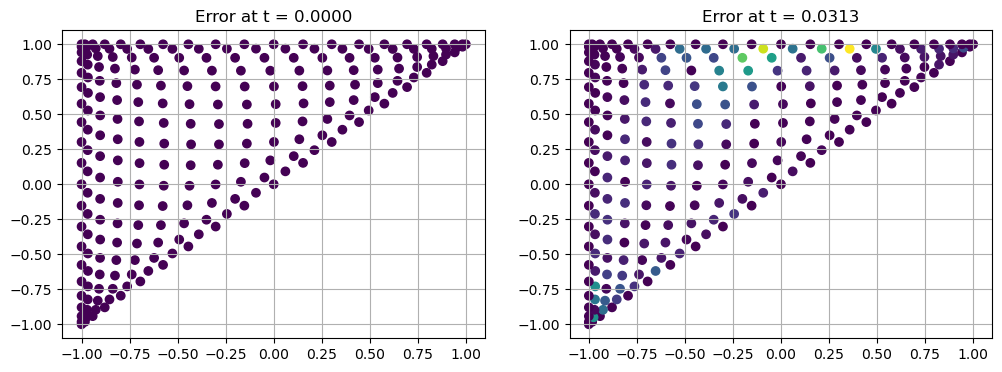

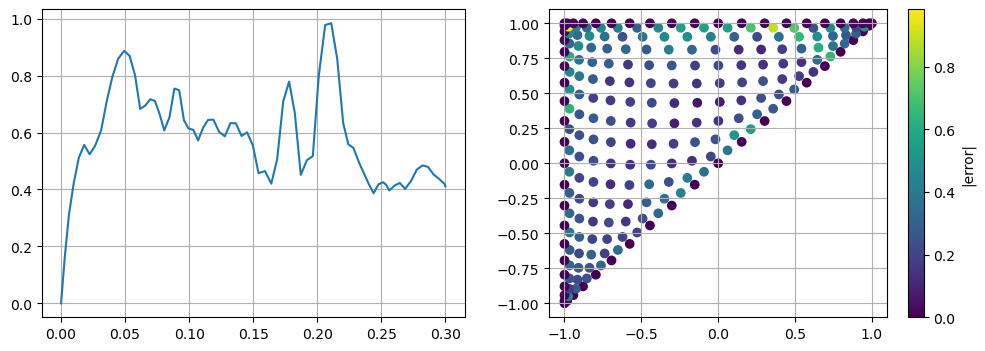

In [99]:
solver_combined = SolverCombined(
    mesh = mesh_hill_1,
    discretization_element = discretization_element_hill_1,
    discretization_mesh = discretization_mesh_hill_1,
    f_rhs = f_rhs_hill,
    g_bc = u_exact_hill,
    g_bc_dt = u_exact_hill_dt,
    advection_velocity_field = advection_velocity_field
)

# dudt = solver_tb.get_rhs_IVP(t=0, u=u_0)
# print(dudt.shape, u_0.shape)

print(t_max)
t0, tf = 0.0, t_max
u_0 = u_exact_hill(x_global, y_global, t=0)
result_scipy = solve_ivp(
    solver_combined.get_rhs_IVP,
    [t0, tf],
    y0 = u_0,
    method = "RK45",
    # max_step = max_step,
    # rtol=rtol,
    # atol=atol
)

u_N_t = result_scipy.y
print(u_N_t.shape)

t_ivp_solver = result_scipy.t

u_true_ivp_solver = u_exact_hill(x_global, y_global, t=t_ivp_solver[:, None]).T

err = np.abs(u_true_ivp_solver - u_N_t)
norm_err_t = np.linalg.norm(err, ord = np.inf, axis=0)
norm_err_xy = np.linalg.norm(err, ord = np.inf, axis=1)
print(f"{err.shape = }")

print(discretization_mesh_hill_1.BC_nodes.shape)
print(err.shape)
np.linalg.norm(err[discretization_mesh_hill_1.BC_nodes], axis = 0, ord = np.inf)

t_test_1, t_test_2 = 0, 10

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x_global, y_global, c = err[:, t_test_1])
ax[0].set_title(f"Error at t = {t_ivp_solver[t_test_1]:.4f}")
ax[0].grid();
ax[1].scatter(x_global, y_global, c = err[:, t_test_2])
ax[1].set_title(f"Error at t = {t_ivp_solver[t_test_2]:.4f}")
ax[1].grid();

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_ivp_solver, norm_err_t)
ax[0].grid();
sc = ax[1].scatter(x_global, y_global, c = norm_err_xy)
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

## Heat equation

In [2]:
from solver_heat import SolverHeatEquation2D

In [3]:
# alpha = 0.1

# def u_exact(x, y, t, alpha=alpha):
#     return np.exp(-2 * (np.pi**2) * alpha * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

# def u_t_exact(x, y, t, alpha=alpha):
#     # ∂_t u = -2 π^2 α e^{-2 π^2 α t} sin(π x) sin(π y)
#     return -2 * (np.pi**2) * alpha * u_exact(x, y, t, alpha=alpha)

# def laplace_u_exact(x, y, t, alpha=alpha):
#     # Δ sin(πx) sin(πy) = -2 π^2 sin(πx) sin(πy); time factor carries through
#     return -2 * (np.pi**2) * u_exact(x, y, t, alpha=alpha)

# def f_rhs(x, y, t, alpha=alpha):
#     # For this exact solution, u_t - α Δu = 0
#     return np.zeros_like(x)

# def g_bc(x, y, t, alpha=alpha):
#     # Dirichlet boundary from exact solution
#     return u_exact(x, y, t, alpha=alpha)

# def g_bc_dt(x, y, t, alpha=alpha):
#     # Time derivative of boundary condition
#     return u_t_exact(x, y, t, alpha=alpha)

# def u0(x, y, alpha=alpha):
#     return u_exact(x, y, 0.0, alpha=alpha) 

In [4]:
alpha = 0.1  # must be the same value passed into SolverHeatEquation2D

def u_exact(x, y, t, alpha=alpha):
    return np.exp(-t) * np.sin(np.pi * x) * np.sin(np.pi * y)

def u_t_exact(x, y, t, alpha=alpha):
    # ∂u/∂t = -e^{-t} sin(pi x) sin(pi y)
    return -np.exp(-t) * np.sin(np.pi * x) * np.sin(np.pi * y)

def laplace_u_exact(x, y, t, alpha=alpha):
    # Δu = -2π^2 e^{-t} sin(pi x) sin(pi y)
    return -2 * (np.pi**2) * np.exp(-t) * np.sin(np.pi * x) * np.sin(np.pi * y)

def f_rhs(x, y, t, alpha=alpha):
    # f = u_t - α Δu
    return u_t_exact(x, y, t, alpha) - alpha * laplace_u_exact(x, y, t, alpha)

def g_bc(x, y, t, alpha=alpha):
    # Dirichlet BC from exact solution
    return u_exact(x, y, t, alpha)

def g_bc_dt(x, y, t, alpha=alpha):
    # Time derivative of BC
    return u_t_exact(x, y, t, alpha)

def u0(x, y, alpha=alpha):
    # Initial condition at t=0
    return u_exact(x, y, 0.0, alpha)

In [5]:
V_x = np.array([-1, 1, 1, -1])
V_y = np.array([-1, -1, 1, 1])
EtoV = np.array([[1, 2, 4], [2, 3, 4]]) - 1
mesh_square = create_toy_mesh(V_x, V_y, EtoV)

# mesh_circle = create_2d_circle(
#     radius=1.0,
#     origin=(0.0, 0.0),
#     mesh_size=1
# )

In [6]:
N = 5
t_max = 1

mesh_heat = mesh_square
# mesh_heat = mesh_circle

discretization_element_heat = create_discretization_element(N = N)
discretization_mesh_heat= create_discretization_mesh(mesh = mesh_heat, discretization_element = discretization_element_heat)

x_global, y_global = discretization_mesh_heat.x_global, discretization_mesh_heat.y_global
BC_nodes = discretization_mesh_heat.BC_nodes

solver_heat = SolverHeatEquation2D(
    mesh = mesh_heat,
    discretization_element = discretization_element_heat,
    discretization_mesh = discretization_mesh_heat,
    f_rhs = f_rhs,
    g_bc = g_bc,
    g_bc_dt = g_bc_dt,
    advection_velocity_field = None,
    alpha = alpha
)

# dudt = solver_tb.get_rhs_IVP(t=0, u=u_0)
# print(dudt.shape, u_0.shape)

print(t_max)
t0, tf = 0.0, t_max
u_0_values = u0(x_global, y_global)
result_scipy = solve_ivp(
    solver_heat.get_rhs_IVP,
    [t0, tf],
    y0 = u_0_values,
    method = "RK45",
    # max_step = max_step,
    # rtol=rtol,
    # atol=atol
)

1


(36, 11)
err.shape = (36, 11)
(36, 11)
1.4102071972183418e-26


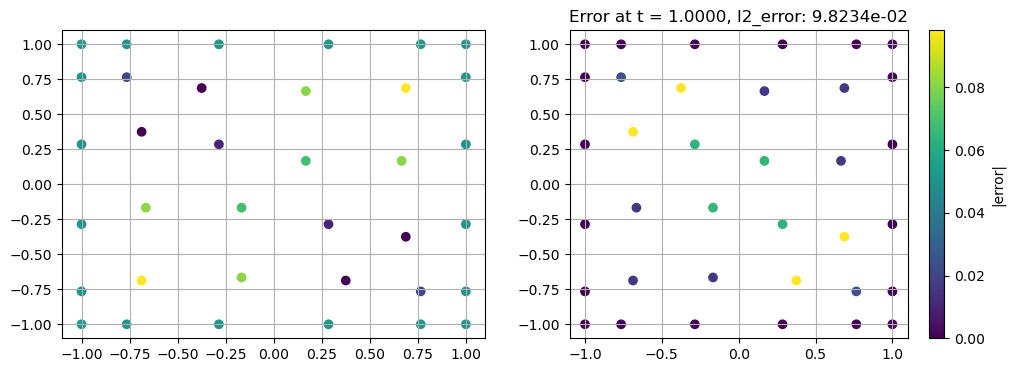

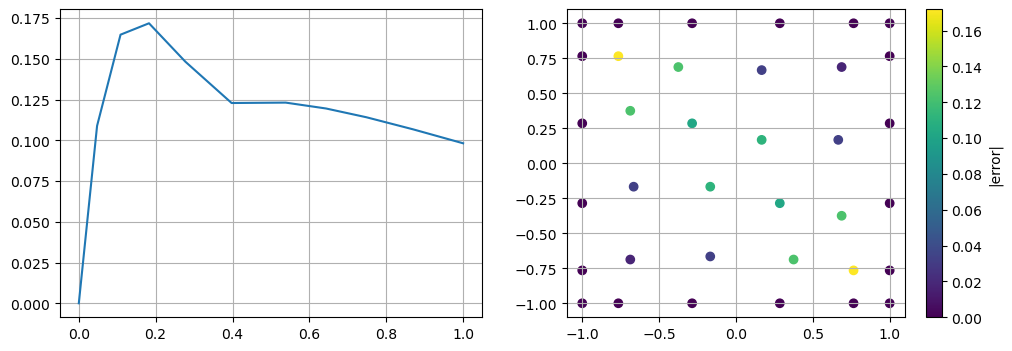

In [7]:
u_N_t = result_scipy.y
print(u_N_t.shape)

t_ivp_solver = result_scipy.t

u_true_ivp_solver = u_exact(x_global, y_global, t=t_ivp_solver[:, None]).T

err = np.abs(u_true_ivp_solver - u_N_t)
norm_err_t = np.linalg.norm(err, ord = np.inf, axis=0)
norm_err_xy = np.linalg.norm(err, ord = np.inf, axis=1)
print(f"{err.shape = }")

print(err.shape)
print(np.linalg.norm(err[BC_nodes], axis = 0, ord = np.inf).max())

t_test_1, t_test_2 = 0, -1

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x_global, y_global, c = u_true_ivp_solver[:, t_test_1])
# ax[0].set_title(f"Error at t = {t_ivp_solver[t_test_1]:.4f}")
ax[0].grid();
sc = ax[1].scatter(x_global, y_global, c = err[:, t_test_2])
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].set_title(f"Error at t = {t_ivp_solver[t_test_2]:.4f}, l2_error: {norm_err_t[t_test_2]:.4e}")
ax[1].grid();

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_ivp_solver, norm_err_t)
ax[0].grid();
sc = ax[1].scatter(x_global, y_global, c = norm_err_xy)
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

In [8]:
# r = np.sqrt(x_global[BC_nodes]**2 + y_global[BC_nodes]**2)
# print(r.min(), r.max())   # do you really get ~1.0 or a wide spread?


def find_shared_and_interior_nodes(C: np.ndarray,
                                   BC_nodes: np.ndarray):
    """
    C:        (K, Mp) local-to-global connectivity
    BC_nodes: (Nb,) global boundary node indices

    Returns:
      shared_nodes:      global nodes that belong to >= 2 elements
      interior_nodes:    global nodes that belong to exactly 1 element
      shared_interior:   shared_nodes \ BC_nodes
    """
    C = np.asarray(C, dtype=int)
    BC_nodes = np.asarray(BC_nodes, dtype=int)

    # Count how many times each global node appears in C
    gidx = int(C.max()) + 1
    counts = np.zeros(gidx, dtype=int)
    np.add.at(counts, C.ravel(), 1)

    # Nodes appearing in >=2 elements are "shared"
    shared_nodes = np.where(counts >= 2)[0]
    # Nodes appearing exactly once are "element-internal" (not shared)
    interior_nodes = np.where(counts == 1)[0]

    # Exclude boundary from shared if you want interior shared nodes only
    shared_interior = np.setdiff1d(shared_nodes, BC_nodes, assume_unique=False)

    return shared_nodes, interior_nodes, shared_interior

In [9]:
def solve_heat_convergence(N, mesh_heat_convergence, t_max = 1, alpha = alpha):
    
    # discretization_element_heat = create_discretization_element(N = N, LocalReorder = np.arange((N+1)*(N+2)//2))
    discretization_element_heat = create_discretization_element(N = N)
    discretization_mesh_heat= create_discretization_mesh(
        mesh = mesh_heat_convergence, discretization_element = discretization_element_heat
    )

    # r, s = discretization_element_hill_1.r, discretization_element_hill_1.s
    x_global, y_global = discretization_mesh_heat.x_global, discretization_mesh_heat.y_global

    solver_heat = SolverHeatEquation2D(
        mesh = mesh_heat_convergence,
        discretization_element = discretization_element_heat,
        discretization_mesh = discretization_mesh_heat,
        f_rhs = f_rhs,
        g_bc = g_bc,
        g_bc_dt = g_bc_dt,
        advection_velocity_field = None,
        alpha = alpha
    )

    u_0 = u0(x_global, y_global)
    result_scipy = solve_ivp(
        solver_heat.get_rhs_IVP,
        [t0, t_max],
        y0 = u_0,
        method = "RK45",
        # max_step = max_step,
        # rtol=rtol,
        # atol=atol
    )
    if result_scipy.success is False:
        print(f"{N = }, {result_scipy.success = }", "IVP solver failed!")

    # u_true_ivp_solver = u_exact(x_global, y_global, t=t_ivp_solver[:, None]).T

    u_t_max = u_exact(x_global, y_global, t=t_max)
    u_num_t_max = result_scipy.y[:, -1]
    err_t_max = np.abs(u_t_max - u_num_t_max)

    error_inf_norm = np.linalg.norm(err_t_max, ord = np.inf)
    # error_inf_norm = np.linalg.norm(err_t_max, ord = 2)

    _, interior_nodes, shared_interior = find_shared_and_interior_nodes(
        discretization_mesh_heat.C,
        discretization_mesh_heat.BC_nodes,
    )

    error_inf_norm_interior = np.linalg.norm(err_t_max[interior_nodes], ord = np.inf)
    error_inf_norm_shared = np.linalg.norm(err_t_max[shared_interior], ord = np.inf)

    return error_inf_norm, error_inf_norm_interior, error_inf_norm_shared

In [10]:
N_array = np.arange(3, 18)
# N_array = np.arange(3, 6)
error_array = np.zeros(N_array.shape[0])
error_interior_array = np.zeros(N_array.shape[0])
error_shared_array = np.zeros(N_array.shape[0])

for i, N in enumerate(tqdm(N_array)):
    # error_inf_norm, error_inf_norm_interior, error_inf_norm_shared =\
    #     solve_heat_convergence(N, t_max = 1, mesh_heat_convergence=mesh_circle)
    error_inf_norm, error_inf_norm_interior, error_inf_norm_shared =\
        solve_heat_convergence(N, t_max = 1, mesh_heat_convergence=mesh_square)
    error_array[i] = error_inf_norm
    error_interior_array[i] = error_inf_norm_interior
    error_shared_array[i] = error_inf_norm_shared

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


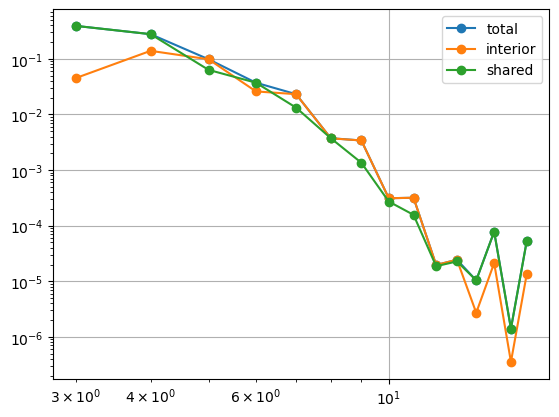

In [11]:
plt.loglog(N_array, error_array, marker='o', label = "total")
plt.loglog(N_array, error_interior_array, marker='o', label = "interior")
plt.loglog(N_array, error_shared_array, marker='o', label = "shared")
plt.legend()
plt.grid()

In [45]:
# u_true_ivp_solver = u_exact(x_global, y_global, t=t_ivp_solver[:, None]).T

# print(u_true_ivp_solver.shape)

# fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
# ax.plot_trisurf(x_global, y_global, u_true_ivp_solver[:, 0], color = "blue", alpha = 1)
# ax.plot_trisurf(x_global, y_global, u_true_ivp_solver[:, 200], color = "red", alpha = 0.5)
# ax.plot_trisurf(x_global, y_global, u_true_ivp_solver[:, -1], color = "green", alpha = 0.5)